# Tikhonov regularization on graphs.
- We shall be using Tikhonov regularization for color processing on graphs(pointclouds).
- To create the graph, see *Graph_construction* notebook.
- We shall be solving the following functinal:

    \begin{equation}\label{eq:optimization_problem}
    f^{*} = \underset{f}{\arg\min} \  \tfrac{1}{2}\|f-f_0\|^2 +  \tfrac{\lambda}{2} \sum_{i \in V}\|\nabla_\omega f_i\|^{2}_{2}
    \end{equation}   
    
- Using the very definition of $\nabla_{w} f$ the regularizer can be expanded as:

\begin{equation}
\sum_{i \in V}\|\nabla_\omega f_i\|^{2}_{2} = \sum_{i \in V} \sum_{j \in N(i)} \omega_{i,j} (f_{j} - f_{i})^{2}
\end{equation}

- It can be shown that for a **symmetric weighted** graph (*i.e* $\omega_{i,j} = \omega_{j,i}$) the derivate of the energy functional wrt $f_i$ yields:
$$ f_i - f_{i,0} + 2\lambda \sum_{j \in N(i)}\omega_{i,j}(f_{i} - f_{j}) = 0$$

- We shall be solving the above linear equatoins using Jacobi's iteration method which yields:
$$ f_{i}^{n+1} = \frac{f_{i,0} + 2\lambda\sum_{j \in N(i)}\omega_{i,j} f^{n}_{j}}{1 + 2\lambda\sum_{j \in N(i)}\omega_{i,j}}$$

- Let the initial estimate $f^{0}_{i} = f_{i,0}$
- **Note**: Observe that for a large value of $\lambda$ this approaches non-local-means on graphs !

In [1]:
import torch
from tqdm import tqdm
from torch_scatter import scatter
from utilities import *
dev = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# load the graph
graph = torch.load("./data/girl_skate.pt")
graph = graph.to(dev)

In [3]:
# To visualize the noisy pointcloud :
displaySur(**dict(position=graph.x.cpu().numpy(), texture=graph.tex.cpu().numpy()))

In [4]:
class Jacobi_iterative(object):
    """
    To apply Jacobi's fixed point iteration scheme
    """
    def __init__(self, graph, **kwargs):
        self.edge_index = graph.edge_index
        self.edge_attr = graph.edge_attr
        self.dim_size = kwargs["dim_size"] 
        self.f0 = kwargs["noisy_sig"] 
        self.lamb = kwargs["lamb"]
        
    def run(self, itr, signal):
        tol = 1e-15
        for i in tqdm(range(itr)):
            num = self.f0 + (2*self.lamb) * (scatter(self.edge_attr * signal[self.edge_index[0]], self.edge_index[1], dim=0, dim_size=self.dim_size, reduce="add"))
            den = 1.0 + (2*self.lamb) * (scatter(self.edge_attr, self.edge_index[1], dim=0, dim_size=self.dim_size, reduce="add"))
            tmp_signal = num/den
            eps = torch.nn.MSELoss()(signal,tmp_signal)
            signal = tmp_signal
            if eps < tol :
                print(f"Tolerance reached at itr:{i}!")
                return signal
        return signal

    

In [5]:
lamb = 0.2
itr = 100
hp = dict(noisy_sig=graph.tex, lamb=lamb, dim_size=graph.tex.shape[0])
j_i = Jacobi_iterative(graph, **hp)
new_sig = j_i.run(itr, graph.tex)

 29%|██▉       | 29/100 [00:00<00:00, 292.55it/s]

Tolerance reached at itr:29!


In [6]:
# Display the processed pointcloud
displaySur(**dict(position=graph.x.cpu().numpy(), texture=new_sig.cpu().numpy()))

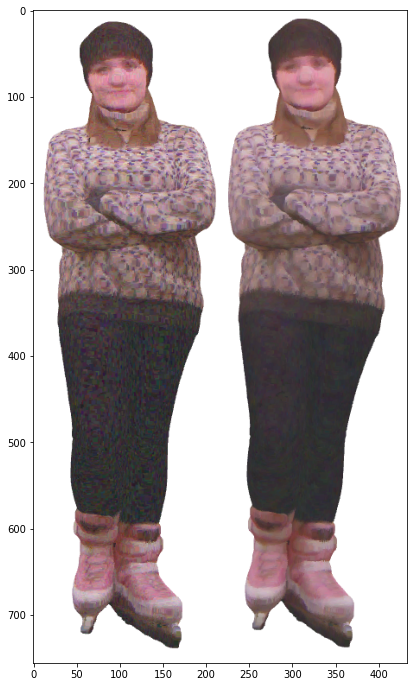

In [7]:
# You should see something like following:
# (Left) noisy pointcloud
# (Right) processed pointcloud
from matplotlib import image as mpimg
from matplotlib import pyplot as plt
res = mpimg.imread("./data/out_color.png")
f = plt.figure(figsize=(12,12))
plt.imshow(res, cmap="gray")
plt.show()